In [1]:
#Importing  necessary libraries

In [5]:
import os
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img, img_to_array
import keras
import sys, time, os, warnings
import numpy as np
import pandas as pd
import string
import progressbar
from collections import Counter
from copy import copy
from keras.models import Model
from tensorflow.keras.applications import ResNet50
from keras.applications.vgg16 import preprocess_input
from collections import OrderedDict
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
warnings.filterwarnings("ignore")

In [2]:
# Getting the Dataset

In [8]:
! pip install -q kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list
! kaggle datasets download waelboussbat/flickr8ksau
! unzip /content/flickr8ksau.zip


Streaming output truncated to the last 5000 lines.
  inflating: flickr8k-sau/Flickr_Data/Images/2844747252_64567cf14a.jpg  
  inflating: flickr8k-sau/Flickr_Data/Images/2844846111_8c1cbfc75d.jpg  
  inflating: flickr8k-sau/Flickr_Data/Images/2844963839_ff09cdb81f.jpg  
  inflating: flickr8k-sau/Flickr_Data/Images/2845246160_d0d1bbd6f0.jpg  
  inflating: flickr8k-sau/Flickr_Data/Images/2845691057_d4ab89d889.jpg  
  inflating: flickr8k-sau/Flickr_Data/Images/2845845721_d0bc113ff7.jpg  
  inflating: flickr8k-sau/Flickr_Data/Images/2846037553_1a1de50709.jpg  
  inflating: flickr8k-sau/Flickr_Data/Images/2846785268_904c5fcf9f.jpg  
  inflating: flickr8k-sau/Flickr_Data/Images/2846843520_b0e6211478.jpg  
  inflating: flickr8k-sau/Flickr_Data/Images/2847514745_9a35493023.jpg  
  inflating: flickr8k-sau/Flickr_Data/Images/2847615962_c330bded6e.jpg  
  inflating: flickr8k-sau/Flickr_Data/Images/2847859796_4d9cb0d31f.jpg  
  inflating: flickr8k-sau/Flickr_Data/Images/2848266893_9693c66275.jpg  


In [ ]:
# Giving the Image and Captions Paths

In [9]:
captions_path = "flickr8k-sau/Flickr_Data/Flickr_TextData/Flickr8k.token.txt"
images_path = "flickr8k-sau/Flickr_Data/Images"

In [ ]:
#Loading Image Files

In [10]:
images = os.listdir(images_path)
len(images)


8091

In [11]:
#Reading Captions File:
file = open(captions_path,'r')
text = file.read()
file.close()

#Processing Text Data
datatxt = []
for line in text.split('\n'):
    col = line.split('\t')
    if len(col) == 1:
        continue
    w = col[0].split("#")
    datatxt.append(w + [col[1].lower()])

#Processing Text Data
df_txt = pd.DataFrame(datatxt,columns=["filename","index","caption"])

#Analyzing Unique Filenames
uni_filenames = np.unique(df_txt.filename.values)
print("The number of unique file names : {}".format(len(uni_filenames)))
print("The distribution of the number of captions for each image:")
#Distribution of Captions:
Counter(Counter(df_txt.filename.values).values())


The number of unique file names : 8092
The distribution of the number of captions for each image:


Counter({5: 8092})

In [12]:
df_txt

,filename,index,caption
0,1000268201_693b08cb0e.jpg,0,a child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,1,a girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,2,a little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,3,a little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,4,a little girl in a pink dress going into a woo...
...,...,...,...
40455,997722733_0cb5439472.jpg,0,a man in a pink shirt climbs a rock face
40456,997722733_0cb5439472.jpg,1,a man is rock climbing high in the air .
40457,997722733_0cb5439472.jpg,2,a person in a red shirt climbing up a rock fac...
40458,997722733_0cb5439472.jpg,3,a rock climber in a red shirt .


In [ ]:
# Loading and displaying Images and Captions

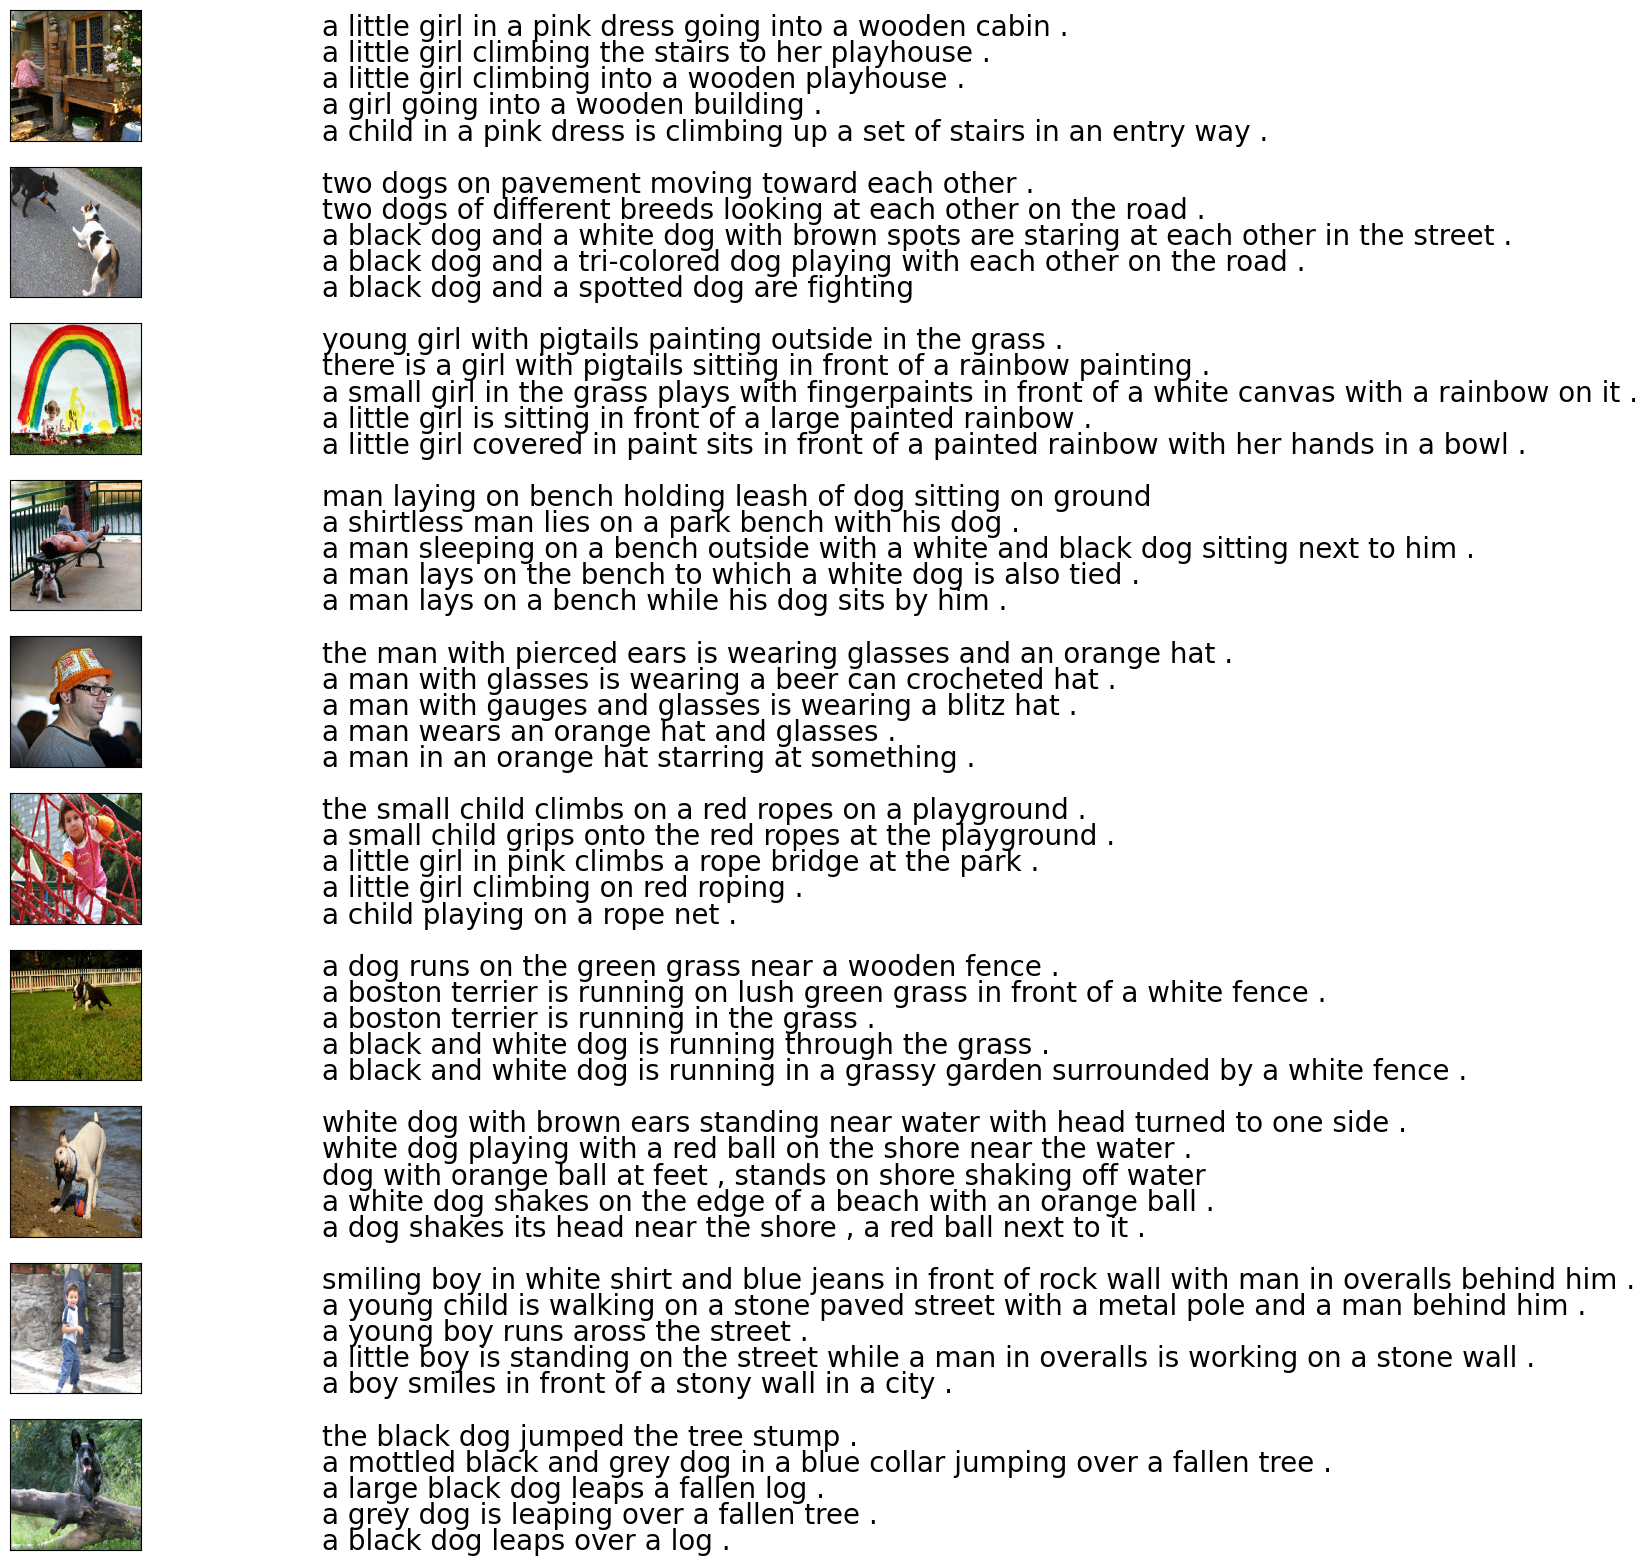

In [7]:
count = 1
fig = plt.figure(figsize=(10,20))
for jpgfnm in uni_filenames[:10]:
    filename = images_path + '/' + jpgfnm
    captions = list(df_txt["caption"].loc[df_txt["filename"]==jpgfnm].values)

    image_load = load_img(filename, target_size=(224,224,3))

    ax = fig.add_subplot(10,2,count,xticks=[],yticks=[])
    ax.imshow(image_load)
    count += 1

    ax = fig.add_subplot(10,2,count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,len(captions))
    for i, caption in enumerate(captions):
        ax.text(0,i,caption,fontsize=20)
    count += 1
plt.show()

In [8]:
del uni_filenames

In [ ]:
# function to generate a DataFrame of word frequencies from image captions, then displays the most common words.

In [13]:
def df_word(df_txt):
    vocabulary = []

    for i in range(len(df_txt)):
        temp=df_txt.iloc[i,2]
        vocabulary.extend(temp.split())

    print('Vocabulary Size: %d' % len(set(vocabulary)))
    ct = Counter(vocabulary)
    dfword = pd.DataFrame({"word":list(ct.keys()),"count":list(ct.values())})
    dfword = dfword.sort_values("count",ascending=False)
    dfword = dfword.reset_index()[["word","count"]]
    return(dfword)

dfword = df_word(df_txt)
dfword.head()


Vocabulary Size: 8918


,word,count
0,a,62989
1,.,36581
2,in,18975
3,the,18419
4,on,10744


In [ ]:
# Plotting most frequently appeared words

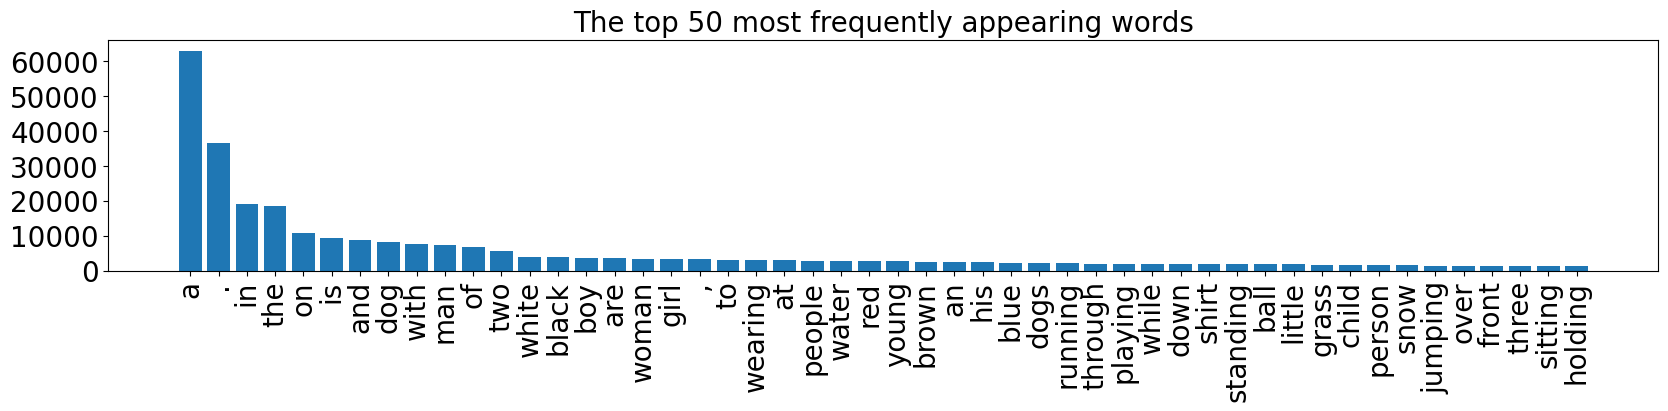

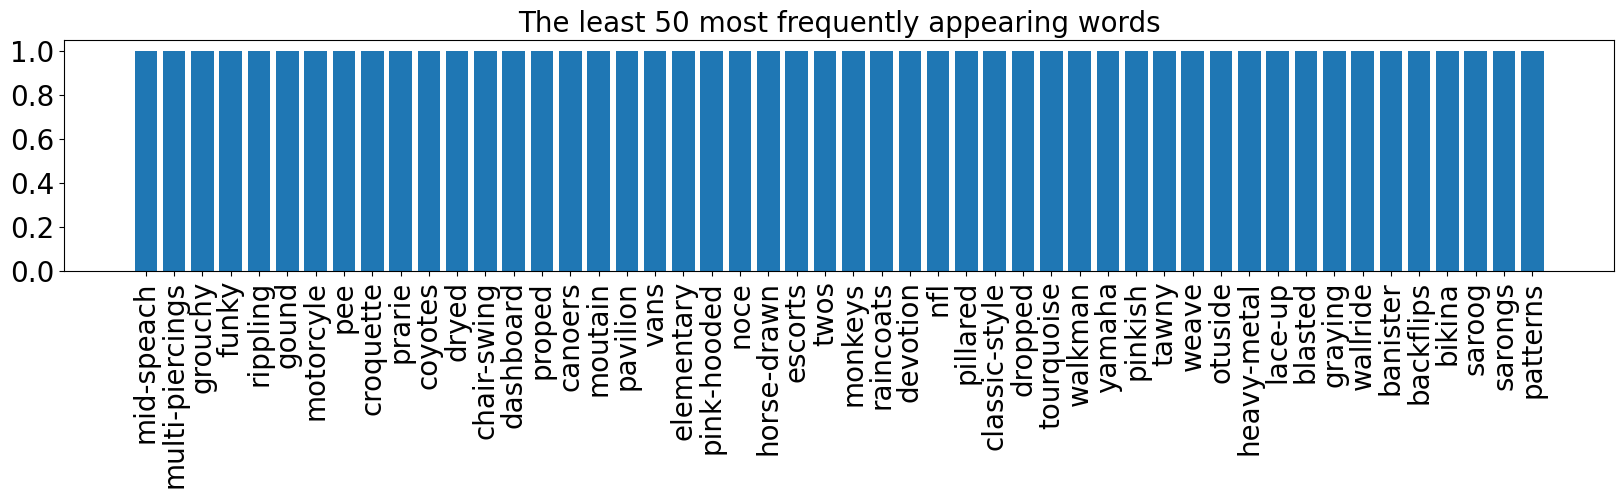

In [10]:
topn = 50

def plthist(dfsub, title="The top 50 most frequently appearing words"):
    plt.figure(figsize=(20,3))
    plt.bar(dfsub.index,dfsub["count"])
    plt.yticks(fontsize=20)
    plt.xticks(dfsub.index,dfsub["word"],rotation=90,fontsize=20)
    plt.title(title,fontsize=20)
    plt.show()

plthist(dfword.iloc[:topn,:],
        title="The top 50 most frequently appearing words")
plthist(dfword.iloc[-topn:,:],
        title="The least 50 most frequently appearing words")

In [14]:
del df_word

In [ ]:
# Data Preprocessing

In [13]:
def remove_punctuation(text_original):
    text_no_punctuation = text_original.translate(str.maketrans('','',string.punctuation))
    return(text_no_punctuation)

def remove_single_character(text):
    text_len_more_than1 = ""
    for word in text.split():
        if len(word) > 1:
            text_len_more_than1 += " " + word
    return(text_len_more_than1)

def remove_numeric(text,printTF=False):
    text_no_numeric = ""
    for word in text.split():
        isalpha = word.isalpha()
        if printTF:
            print("    {:10} : {:}".format(word,isalpha))
        if isalpha:
            text_no_numeric += " " + word
    return(text_no_numeric)

In [ ]:
# Cleaning Text

In [14]:
def text_clean(text_original):
    text = remove_punctuation(text_original)
    text = remove_single_character(text)
    text = remove_numeric(text)
    return(text)

with progressbar.ProgressBar(max_value=len(df_txt.caption.values)) as bar:
    for i, caption in enumerate(df_txt.caption.values):
        newcaption = text_clean(caption)
        df_txt["caption"].iloc[i] = newcaption
        bar.update(i)

100% (40460 of 40460) |##################| Elapsed Time: 0:00:17 Time:  0:00:17


In [ ]:
# function to add "startseq" and "endseq" tokens to each caption

In [15]:
def add_start_end_seq_token(captions):
    caps = []
    for txt in captions:
        txt = 'startseq ' + txt + ' endseq'
        caps.append(txt)
    return(caps)

df_captions = copy(df_txt)
df_captions["caption"] = add_start_end_seq_token(df_txt["caption"])
del df_txt
df_captions

,filename,index,caption
0,1000268201_693b08cb0e.jpg,0,startseq child in pink dress is climbing up s...
1,1000268201_693b08cb0e.jpg,1,startseq girl going into wooden building endseq
2,1000268201_693b08cb0e.jpg,2,startseq little girl climbing into wooden pla...
3,1000268201_693b08cb0e.jpg,3,startseq little girl climbing the stairs to h...
4,1000268201_693b08cb0e.jpg,4,startseq little girl in pink dress going into...
...,...,...,...
40455,997722733_0cb5439472.jpg,0,startseq man in pink shirt climbs rock face e...
40456,997722733_0cb5439472.jpg,1,startseq man is rock climbing high in the air...
40457,997722733_0cb5439472.jpg,2,startseq person in red shirt climbing up rock...
40458,997722733_0cb5439472.jpg,3,startseq rock climber in red shirt endseq


In [16]:
# initializing a pre-trained ResNet50 model
resnet_model = ResNet50(include_top=True)

102967424/102967424 [==============================] - 1s 0us/step


In [17]:
from keras.models import Model
last = resnet_model.layers[-2].output
res_model = Model(inputs = resnet_model.input,outputs = last)
res_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [ ]:
#   processesing a set of images through a modified ResNet50 model

In [18]:
images1 = OrderedDict()
npix = 224
target_size = (npix,npix,3)
with progressbar.ProgressBar(max_value=len(images)) as bar:
    for i,name in enumerate(images):
        # load an image from file
        filename = images_path + '/' + name
        image = load_img(filename, target_size=target_size)
        # convert the image pixels to a numpy array
        image = img_to_array(image)
        nimage = preprocess_input(image)
        y_pred = res_model.predict(nimage.reshape( (1,) + nimage.shape[:3]))
        images1[name] = y_pred.flatten()
        bar.update(i)
del images

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Data Filtering and Preparation for Image Captioning

In [19]:
dimages, keepindex = [],[]
df_captions = df_captions.loc[df_captions["index"].values == "0",: ]

for i, fnm in enumerate(df_captions.filename):
    if fnm in images1.keys():
        dimages.append(images1[fnm])
        keepindex.append(i)

fnames = df_captions["filename"].iloc[keepindex].values
dcaptions = df_captions["caption"].iloc[keepindex].values
dimages = np.array(dimages)
print(df_captions["index"][:5])

0     0
5     0
10    0
15    0
20    0
Name: index, dtype: object


In [20]:
df_captions


,filename,index,caption
0,1000268201_693b08cb0e.jpg,0,startseq child in pink dress is climbing up s...
5,1001773457_577c3a7d70.jpg,0,startseq black dog and spotted dog are fighti...
10,1002674143_1b742ab4b8.jpg,0,startseq little girl covered in paint sits in...
15,1003163366_44323f5815.jpg,0,startseq man lays on bench while his dog sits...
20,1007129816_e794419615.jpg,0,startseq man in an orange hat starring at som...
...,...,...,...
40435,990890291_afc72be141.jpg,0,startseq man does wheelie on his bicycle on t...
40440,99171998_7cc800ceef.jpg,0,startseq group is sitting around snowy crevas...
40445,99679241_adc853a5c0.jpg,0,startseq grey bird stands majestically on bea...
40450,997338199_7343367d7f.jpg,0,startseq person stands near golden walls endseq


In [21]:
del keepindex

In [ ]:
# Text Tokenization and Vocabulary Preparation

In [22]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(dcaptions)
vocab_size = len(tokenizer.word_index) + 1
print("vocabulary size : {}".format(vocab_size))
dtexts = tokenizer.texts_to_sequences(dcaptions)
print(dtexts[:5])

vocabulary size : 4476
[[1, 38, 3, 66, 144, 7, 124, 52, 406, 9, 367, 3, 24, 2351, 522, 2], [1, 12, 8, 5, 752, 8, 17, 368, 2], [1, 48, 15, 170, 3, 584, 101, 3, 41, 9, 551, 1198, 11, 55, 213, 3, 1076, 2], [1, 10, 621, 6, 150, 27, 23, 8, 101, 46, 112, 2], [1, 10, 3, 24, 82, 96, 1199, 19, 162, 2]]


In [ ]:
# Train and Test Split

In [23]:
Ntest = int(len(dtexts)*0.2)

def split_test_train(dtexts,Ntest):
    return(dtexts[:Ntest],
           dtexts[Ntest:])

dt_test, dt_train   = split_test_train(dtexts,Ntest)
di_test, di_train   = split_test_train(dimages,Ntest)
fnm_test, fnm_train  = split_test_train(fnames,Ntest)

In [24]:
del df_captions
del images1


In [ ]:
# Finding Maximum Length of Tokenized Captions

In [25]:
maxlen = np.max([len(text) for text in dtexts])

In [ ]:
# Data Preprocessing for Caption Generation







In [26]:
def preprocessing(dtexts,dimages):
    N = len(dtexts)
    print("# captions/images = {}".format(N))

    assert(N==len(dimages))
    Xtext, Ximage, ytext = [],[],[]
    for text,image in zip(dtexts,dimages):

        for i in range(1,len(text)):
            in_text, out_text = text[:i], text[i]
            in_text = pad_sequences([in_text],maxlen=maxlen).flatten()
            out_text = to_categorical(out_text,num_classes = vocab_size)

            Xtext.append(in_text)
            Ximage.append(image)
            ytext.append(out_text)

    Xtext  = np.array(Xtext)
    Ximage = np.array(Ximage)
    ytext  = np.array(ytext)
    print(" {} {} {}".format(Xtext.shape,Ximage.shape,ytext.shape))
    return(Xtext,Ximage,ytext)


Xtext_train, Ximage_train, ytext_train = preprocessing(dt_train,di_train)

# captions/images = 6473
 (65984, 30) (65984, 2048) (65984, 4476)


In [ ]:
# Combined Model Definition using LSTM layers

In [27]:
from keras import layers
from keras.regularizers import l2
from keras import models

print(vocab_size)
## image feature

dim_embedding = 128

input_image = layers.Input(shape=(Ximage_train.shape[1],))
droplayer1 = layers.Dropout(0.5)(input_image)
BN = layers.BatchNormalization()(droplayer1)
fimage1 = layers.Dense(256,activation='relu',name="ImageFeature1",kernel_regularizer=l2(0.01))(BN)
droplayer1 = layers.Dropout(0.5)(fimage1)
BN = layers.BatchNormalization()(droplayer1)
fimage1 = layers.Dense(256,activation='relu',name="ImageFeature3",kernel_regularizer=l2(0.01))(BN)
droplayer2 = layers.Dropout(0.5)(fimage1)
BN = layers.BatchNormalization()(droplayer2)
fimage2 = layers.Dense(256, activation='relu')(BN)


## sequence model
input_txt = layers.Input(shape=(np.max([len(text) for text in dtexts]),))
ftxt = layers.Embedding(vocab_size,dim_embedding, mask_zero=True)(input_txt)
droplayer_ = layers.Dropout(0.5)(ftxt)
BN = layers.BatchNormalization()(droplayer_)
ftxt = layers.LSTM(256,name="CaptionFeature")(BN)

## sequence model
input_txt = layers.Input(shape=(np.max([len(text) for text in dtexts]),))
ftxt = layers.Embedding(vocab_size,dim_embedding, mask_zero=True)(input_txt)
droplayer_ = layers.Dropout(0.5)(ftxt)
BN = layers.BatchNormalization()(droplayer_)
ftxt = layers.LSTM(256,name="CaptionFeature")(BN)


## combined model for decoder
decoder = layers.add([ftxt,fimage2])
decoder = layers.Dense(256,activation='relu')(decoder)
droplayer1 = layers.Dropout(0.5)(decoder)
BN = layers.BatchNormalization()(droplayer1)
output = layers.Dense(vocab_size,activation='softmax')(BN)
model = models.Model(inputs=[input_image, input_txt],outputs=output)

model.compile(loss='categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])

print(model.summary())

4476
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 2048)]               0         []                            
                                                                                                  
 dropout (Dropout)           (None, 2048)                 0         ['input_2[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 2048)                 8192      ['dropout[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 ImageFeature1 (Dense)       (None, 256)                  524544    ['batch_normalizati

In [32]:
# image features extractor model
from keras.layers import Input,Dropout,Dense,LSTM,add,Embedding
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

# input sequence model
inputs2 = Input(shape=(maxlen,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

# decoder model OR output word model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

# tie it together [image, seq] [word]
model3 = Model(inputs=[inputs1, inputs2], outputs=outputs)
model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# summarize model
model3.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 30)]                 0         []                            
                                                                                                  
 input_7 (InputLayer)        [(None, 2048)]               0         []                            
                                                                                                  
 embedding_2 (Embedding)     (None, 30, 256)              1145856   ['input_8[0][0]']             
                                                                                                  
 dropout_7 (Dropout)         (None, 2048)                 0         ['input_7[0][0]']             
                                                                                            

In [34]:
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, RepeatVector, Embedding, LSTM, TimeDistributed, Concatenate, Bidirectional, Activation, Input
from tensorflow.keras.models import Model

embedding_size = 300

image_model = Sequential()
image_model.add(Dense(embedding_size, input_shape=(2048,), activation='relu'))
image_model.add(RepeatVector(30))

sequence_model = Sequential()
sequence_model.add(Embedding(vocab_size, embedding_size, input_length=maxlen))
sequence_model.add(LSTM(256, return_sequences=True))
sequence_model.add(TimeDistributed(Dense(300)))

conc = Concatenate()([image_model.output, sequence_model.output])
x = Bidirectional(LSTM(256, return_sequences=False))(conc)
x = Dense(vocab_size)(x)
out = Activation('softmax')(x)

model4 = Model(inputs=[image_model.input, sequence_model.input], outputs = out)
model4.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])
model4.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 embedding_3_input (InputLa  [(None, 30)]                 0         []                            
 yer)                                                                                             
                                                                                                  
 dense_6_input (InputLayer)  [(None, 2048)]               0         []                            
                                                                                                  
 embedding_3 (Embedding)     (None, 30, 300)              1342800   ['embedding_3_input[0][0]']   
                                                                                                  
 dense_6 (Dense)             (None, 300)                  614700    ['dense_6_input[0][0]'] 